# User Behaviour Analysis Based on Borrowing Dates

This notebook explores user behaviour with respect to borrowing dates

We investigate how weekdays could affect borrowings.\
The goal is to identify temporal trends in borrowing behaviour and to obtain a more comprehensive picture of user behavior.


In [1]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


In [2]:
# --- load data ---

borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (2313072, 21)


In [3]:
# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"

USER_ID_COL = "Benutzer-Systemnummer"
USER_CATEGORY_COL = "Benutzerkategorie"

LATE_FLAG_COL = "Verspätet"

borrowings[USER_ID_COL] = pd.to_numeric(borrowings[USER_ID_COL], errors="coerce").astype("Int64")

borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA>
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")



### Collecting multiple loans into sessions
All loans by a user on a day make up a session.

In [4]:

df_sessions = borrowings.copy()
df_sessions["session_time"] = df_sessions[ISSUE_COL].dt.floor("D")

user_sessions = df_sessions.groupby([USER_ID_COL, "session_time"]).size().reset_index(name="items_borrowed")
user_sessions["weekday"] = user_sessions["session_time"].dt.day_name()


In [5]:
MIN_SESSIONS = 3
session_day_counts = user_sessions.groupby([USER_ID_COL, 'weekday']).size().unstack(fill_value=0)

# Top-Day-Percentage based on visits
session_consistency = (session_day_counts.max(axis=1) / session_day_counts.sum(axis=1)) * 100

frequent_user_mask = session_day_counts.sum(axis=1) >= MIN_SESSIONS
clean_consistency = session_consistency[frequent_user_mask]

print(f"Based on {len(clean_consistency)} users with >= {MIN_SESSIONS} visits.")
print(clean_consistency.describe())

Based on 15806 users with >= 3 visits.
count   15,806.0000
mean        42.7866
std         15.5018
min         16.6667
25%         31.8182
50%         38.4615
75%         50.0000
max        100.0000
dtype: float64


In [6]:
session_day_counts.head()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Benutzer-Systemnummer,,,,,,,
46,3,0,0,0,0,0,0
50,104,30,51,0,125,181,150
51,2,0,1,0,6,6,1
53,0,0,0,0,2,1,0
54,50,4,43,0,40,48,47


Quantify user routine by calculating the distribution of visits across weekdays and identifying the share of visits occurring on the most frequent day (Favorite Day Consistency)

The mean consistency of 42.8% indicates that, on average users perform nearly half of their borrowing sessions on their most preferred weekday. Compared to a theoretical random distribution of 20% (assuming 5 opening days), this could suggest a behavioral routine among frequent users

/var/folders/zr/spgxm1td597dgv39lljd_8tr0000gn/T/ipykernel_25598/497821977.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


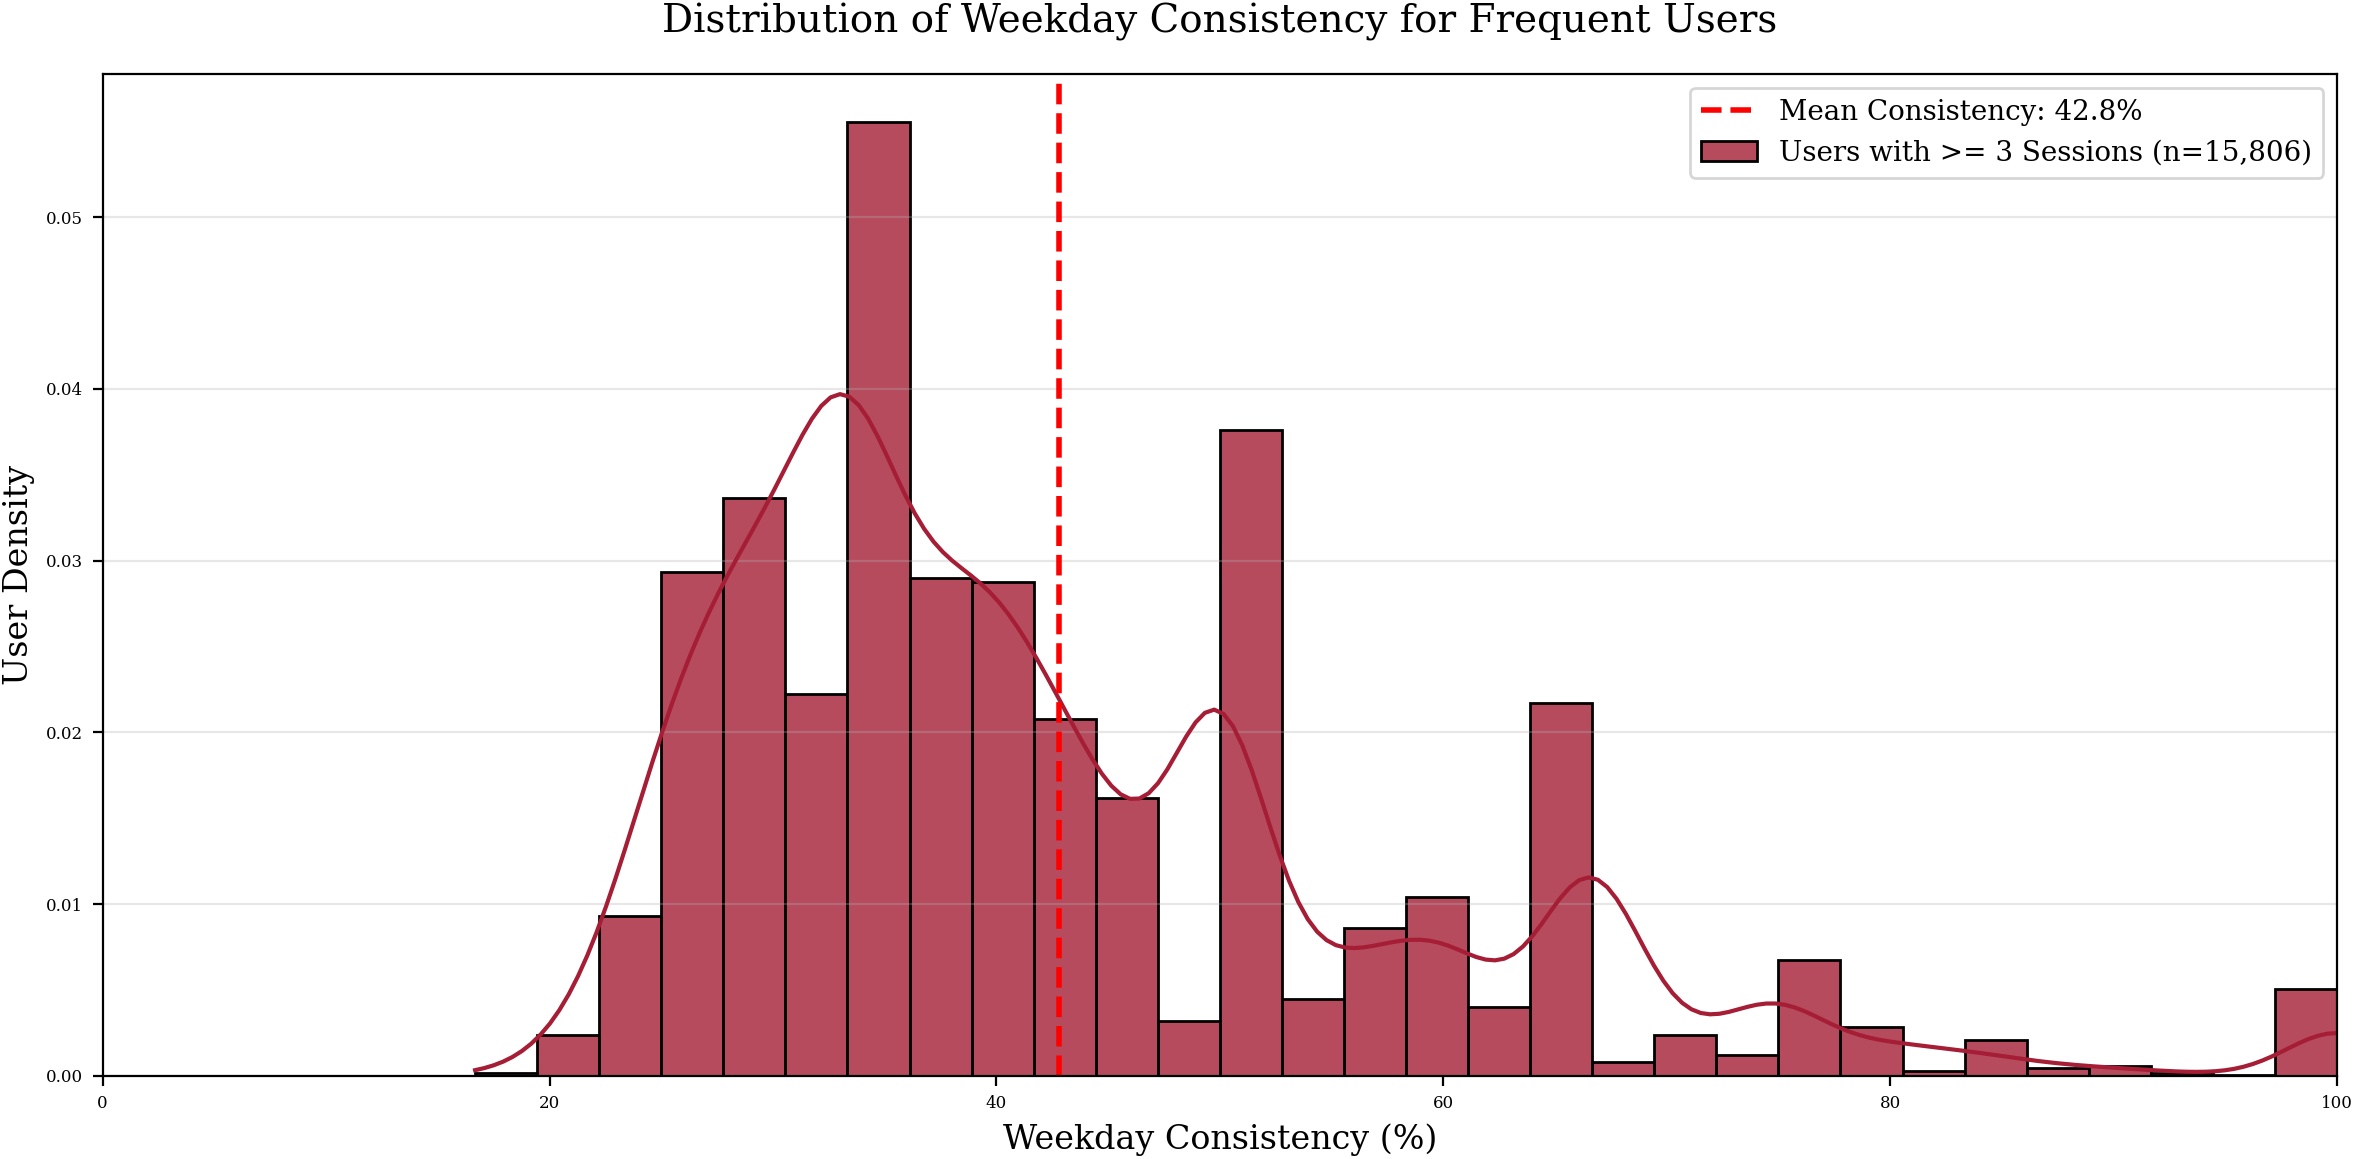

In [7]:

mean_val = clean_consistency.mean()

plt.figure(figsize=(12, 6))

sns.histplot(
    clean_consistency, 
    bins=30, 
    kde=True, 
    alpha=0.8, 
    label=f'Users with >= {MIN_SESSIONS} Sessions (n={len(clean_consistency):,})', 
    stat="density", 
    common_norm=False
)

plt.axvline(
    mean_val, 
    color='red', 
    linestyle='--', 
    linewidth=2, 
    label=f'Mean Consistency: {mean_val:.1f}%'
)

plt.title('Distribution of Weekday Consistency for Frequent Users', fontsize=14, pad=15)
plt.xlabel('Weekday Consistency (%)', fontsize=12)
plt.ylabel('User Density', fontsize=12)

plt.xlim(0, 100)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

The distribution would also enable a possible grouping of users based on their consistency.


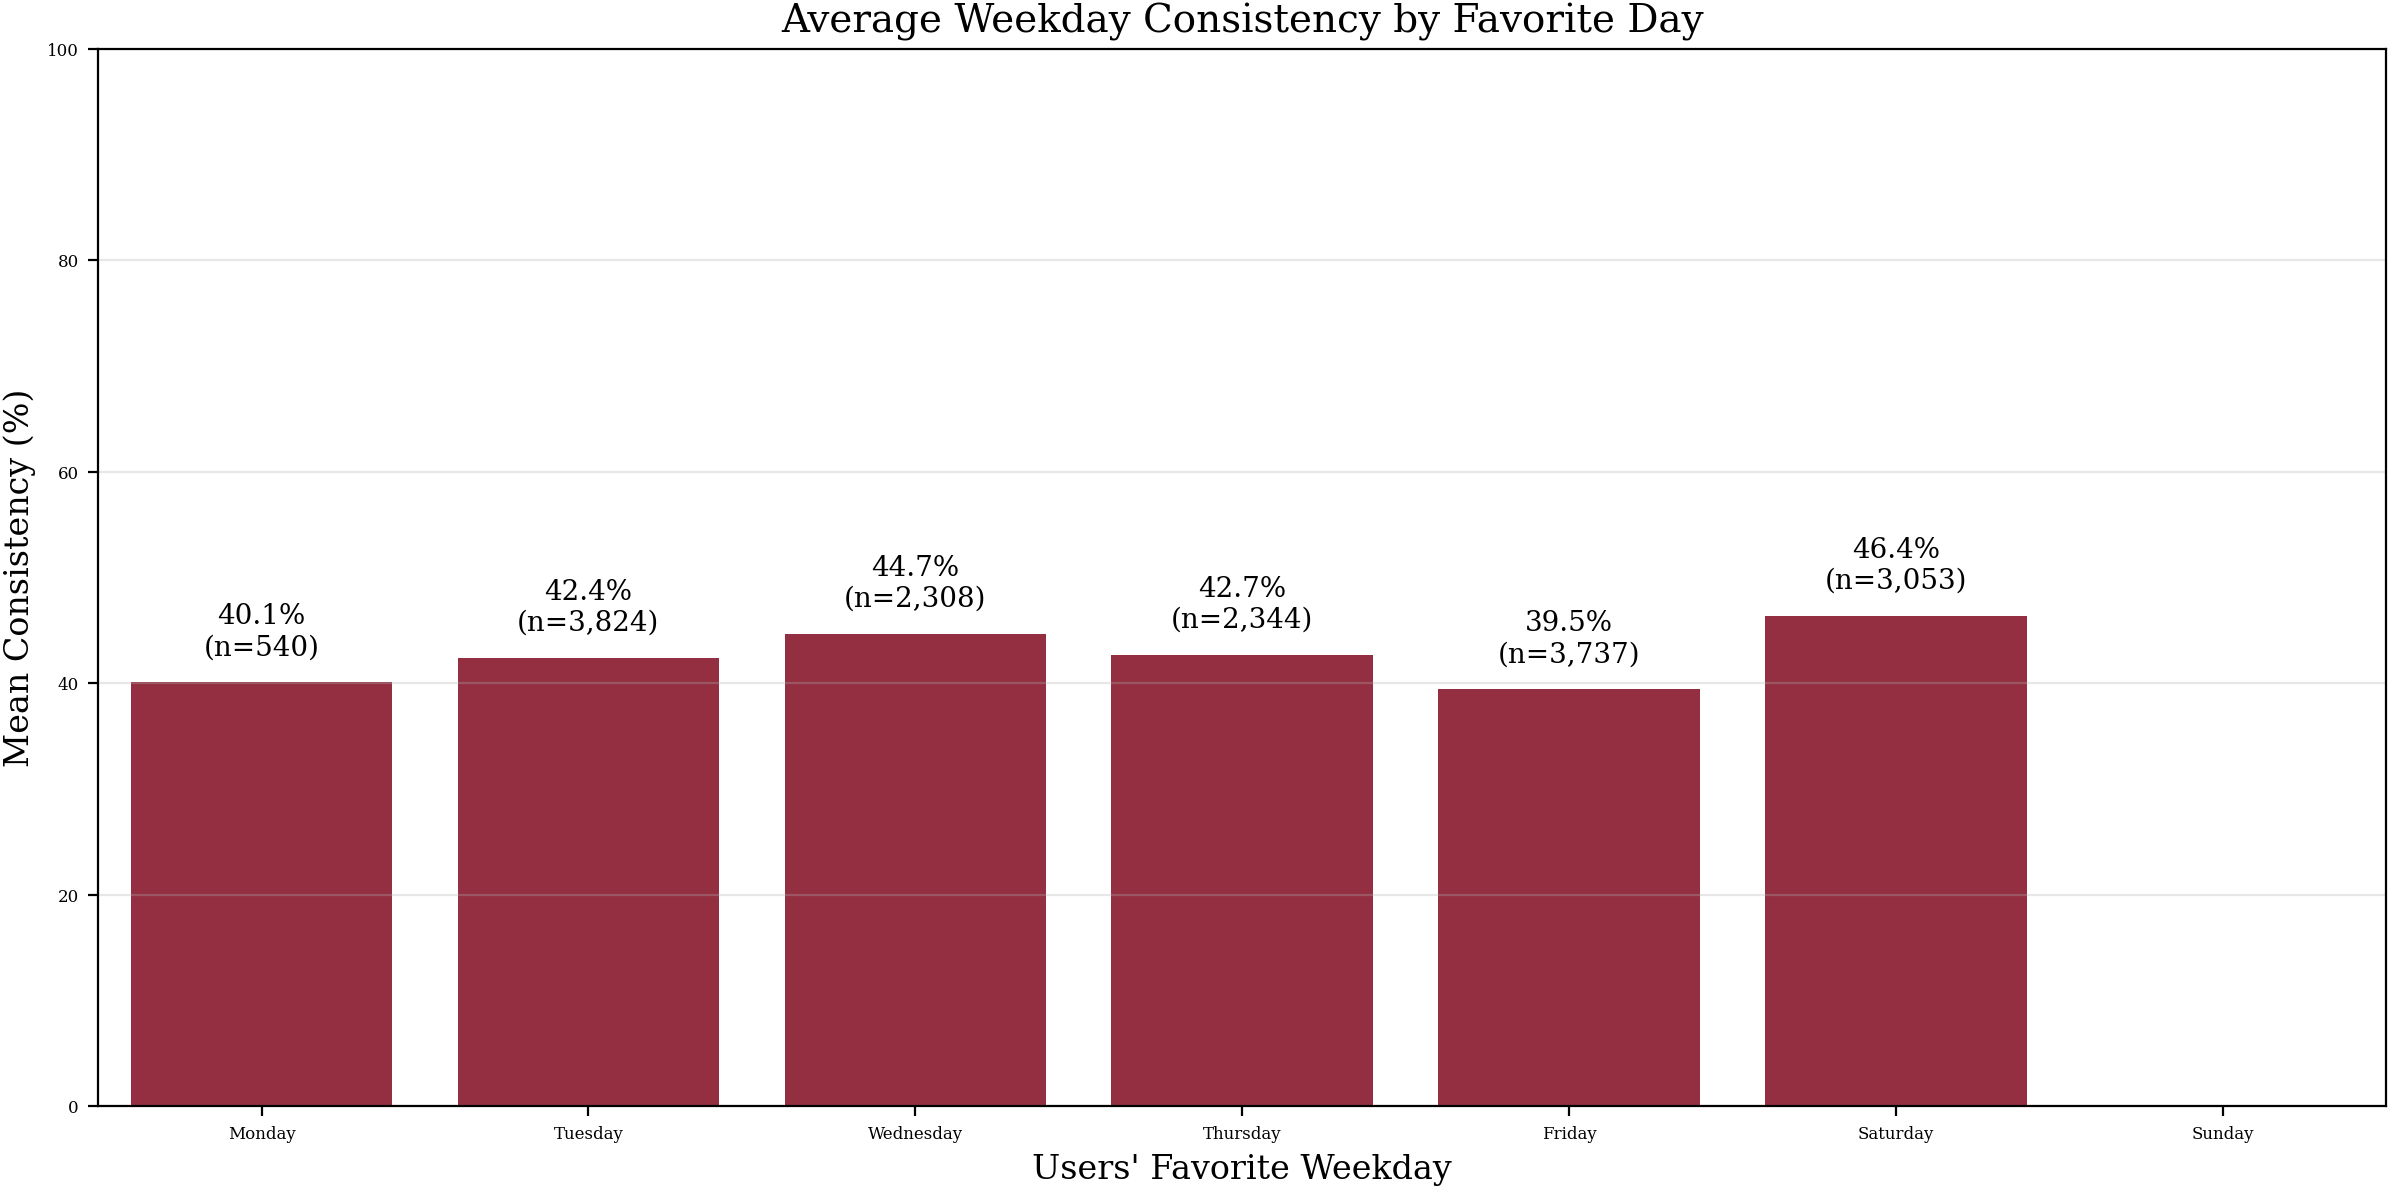

In [11]:
# Identify the favorite day for each user
favorite_days = session_day_counts.idxmax(axis=1)
favorite_days_df = favorite_days.to_frame(name='favorite_weekday')

# Merge with consistency metrics
consistency_comparison = favorite_days_df.merge(
    clean_consistency.to_frame(name='consistency'), 
    left_index=True, 
    right_index=True
)

#Calculate average consistency per favorite day
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_stats = (
    consistency_comparison.groupby('favorite_weekday')['consistency']
    .agg(['mean', 'count'])
    .reindex(day_order)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=day_stats.index, 
    y=day_stats['mean'], 
)

plt.title('Average Weekday Consistency by Favorite Day', fontsize=14)
plt.xlabel('Users\' Favorite Weekday', fontsize=12)
plt.ylabel('Mean Consistency (%)', fontsize=12)
plt.ylim(0, 100)

for i, row in enumerate(day_stats.itertuples()):
    if not pd.isna(row.mean):
        plt.text(i, row.mean + 2, f"{row.mean:.1f}%\n(n={int(row.count):,})", 
                 ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.show()

No matter what day of the week, users show a steady level of consistency.